In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import torch 
from torch import nn, optim
from copy import deepcopy as copy
import pandas as pd

from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from scipy.stats import wasserstein_distance

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)

In [4]:
hidden_dim = 20
embedding_dim = 5
n_tokens = 100
n_tokens_p_sentences = 10
n_sentences = 30
n_clients = 20

In [5]:
def generate_clients(n_clusters=1, e=1, n_sentences = n_sentences, n_tokens_p_setence = n_tokens_p_sentences, n_clients = n_clients):

    clients = []
    for client in range(n_clients):
        w_ie = np.random.normal(0, e, size=(embedding_dim, n_tokens))
        w_eh = np.random.normal(0, e, size=(hidden_dim, embedding_dim))
        w_hh = np.random.normal(0, e, size=(hidden_dim, hidden_dim))   
        w_ho = np.random.normal(0, e, size=(n_tokens, hidden_dim))
        tokens = []
        
        init_token = client % n_clusters
        for _ in range(n_sentences):
            hidden = np.zeros(hidden_dim) 
            token_n = init_token
            tokens.append(token_n)
            for _ in range(n_tokens_p_setence - 1):
                one_hot = np.zeros(n_tokens)
                one_hot[token_n] = 1
                embedding = w_ie @ one_hot 
                hidden = np.tanh(w_hh @ hidden + w_eh @ embedding)
                output = w_ho @ hidden 
                softmax = np.exp(output) / np.sum(np.exp(output))
                token_n = np.random.choice(range(n_tokens), p=softmax)
                tokens.append(token_n) 
        clients.append(tokens)
    return torch.tensor(clients).reshape(n_clients, n_sentences, -1)

In [6]:
class RNN(nn.Module):
    
    def __init__(self, n_tokens, embedding_dim, hidden_dim, batch_size):
        super(RNN, self).__init__()
        self.E = nn.Embedding(n_tokens, embedding_dim)
        self.rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_dim, nonlinearity='tanh', bias=False)
        self.W_ho = nn.Linear(hidden_dim, n_tokens, bias=False)
        self.softmax = nn.Softmax(dim=1)
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim

    def forward(self, x):
        e = self.E(x)
        hidden, _ = self.rnn(e)
        output = self.softmax(self.W_ho(hidden))
        return output
    
    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_dim)

    """
        Utility functions to take average of models
    """
    
    def __add__(self, other):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param, other_param in zip(my_copy.parameters(), other.parameters()):
                self_param.data += other_param.data
        return my_copy
    
    def __truediv__(self, n):
        my_copy = copy(self)
        with torch.no_grad():
            for self_param in my_copy.parameters():
                self_param.data /= n
        return my_copy
    
    def zero(self):
        for self_param in self.parameters():
            self_param.data = torch.zeros_like(self_param.data)
        return self

# E = 1

In [7]:
clients = generate_clients()

In [8]:
loss_fn = nn.NLLLoss()
batch_size = 10
lr = 0.01
n_steps = 1000

In [9]:
all_steps = [[[] for _ in range(n_steps)] for _ in range(n_clients)]
losses = [[] for _ in range(n_clients)]
acc = [[] for _ in range(n_clients)]

final_models = []
for client in range(n_clients):
    print(client)
    model = RNN(n_tokens, embedding_dim, hidden_dim-10, batch_size)
    optimizer = optim.Adam(lr=lr, params=model.parameters())

    for step in range(n_steps):
        for name, param in model.named_parameters():
            all_steps[client][step].extend(list(param.view(-1).detach().numpy()))
        
        batch_idx = np.random.choice(range(n_sentences), batch_size)
        X,Y = clients[client][batch_idx,:-1], clients[client][batch_idx,1:]
        optimizer.zero_grad()
        predict = model(X)
        loss = loss_fn(predict.reshape(-1, n_tokens), Y.reshape(-1))
        loss.backward()
        optimizer.step()
        
        acc[client].append(torch.sum(torch.argmax(predict, dim=2) == Y).item() / (X.shape[0] * X.shape[1]))
        losses[client].append(loss.item())
    final_models.append(model)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [10]:
runs = pd.DataFrame(columns = ['client', 'step', 'loss', 'accuracy'])
runs['client'] = [i for i in range(n_clients) for _ in range(n_steps)]
runs['step'] = list(range(n_steps)) * n_clients
runs['loss'] = np.array(losses).reshape(-1)
runs['loss_smooth'] = np.concatenate([runs['loss'][1000*i:1000*(i+1)].rolling(40).mean() for i in range(0,20)])
runs['accuracy'] = np.array(acc).reshape(-1)
runs['accuracy_smooth'] = runs['accuracy'].rolling(40).mean()

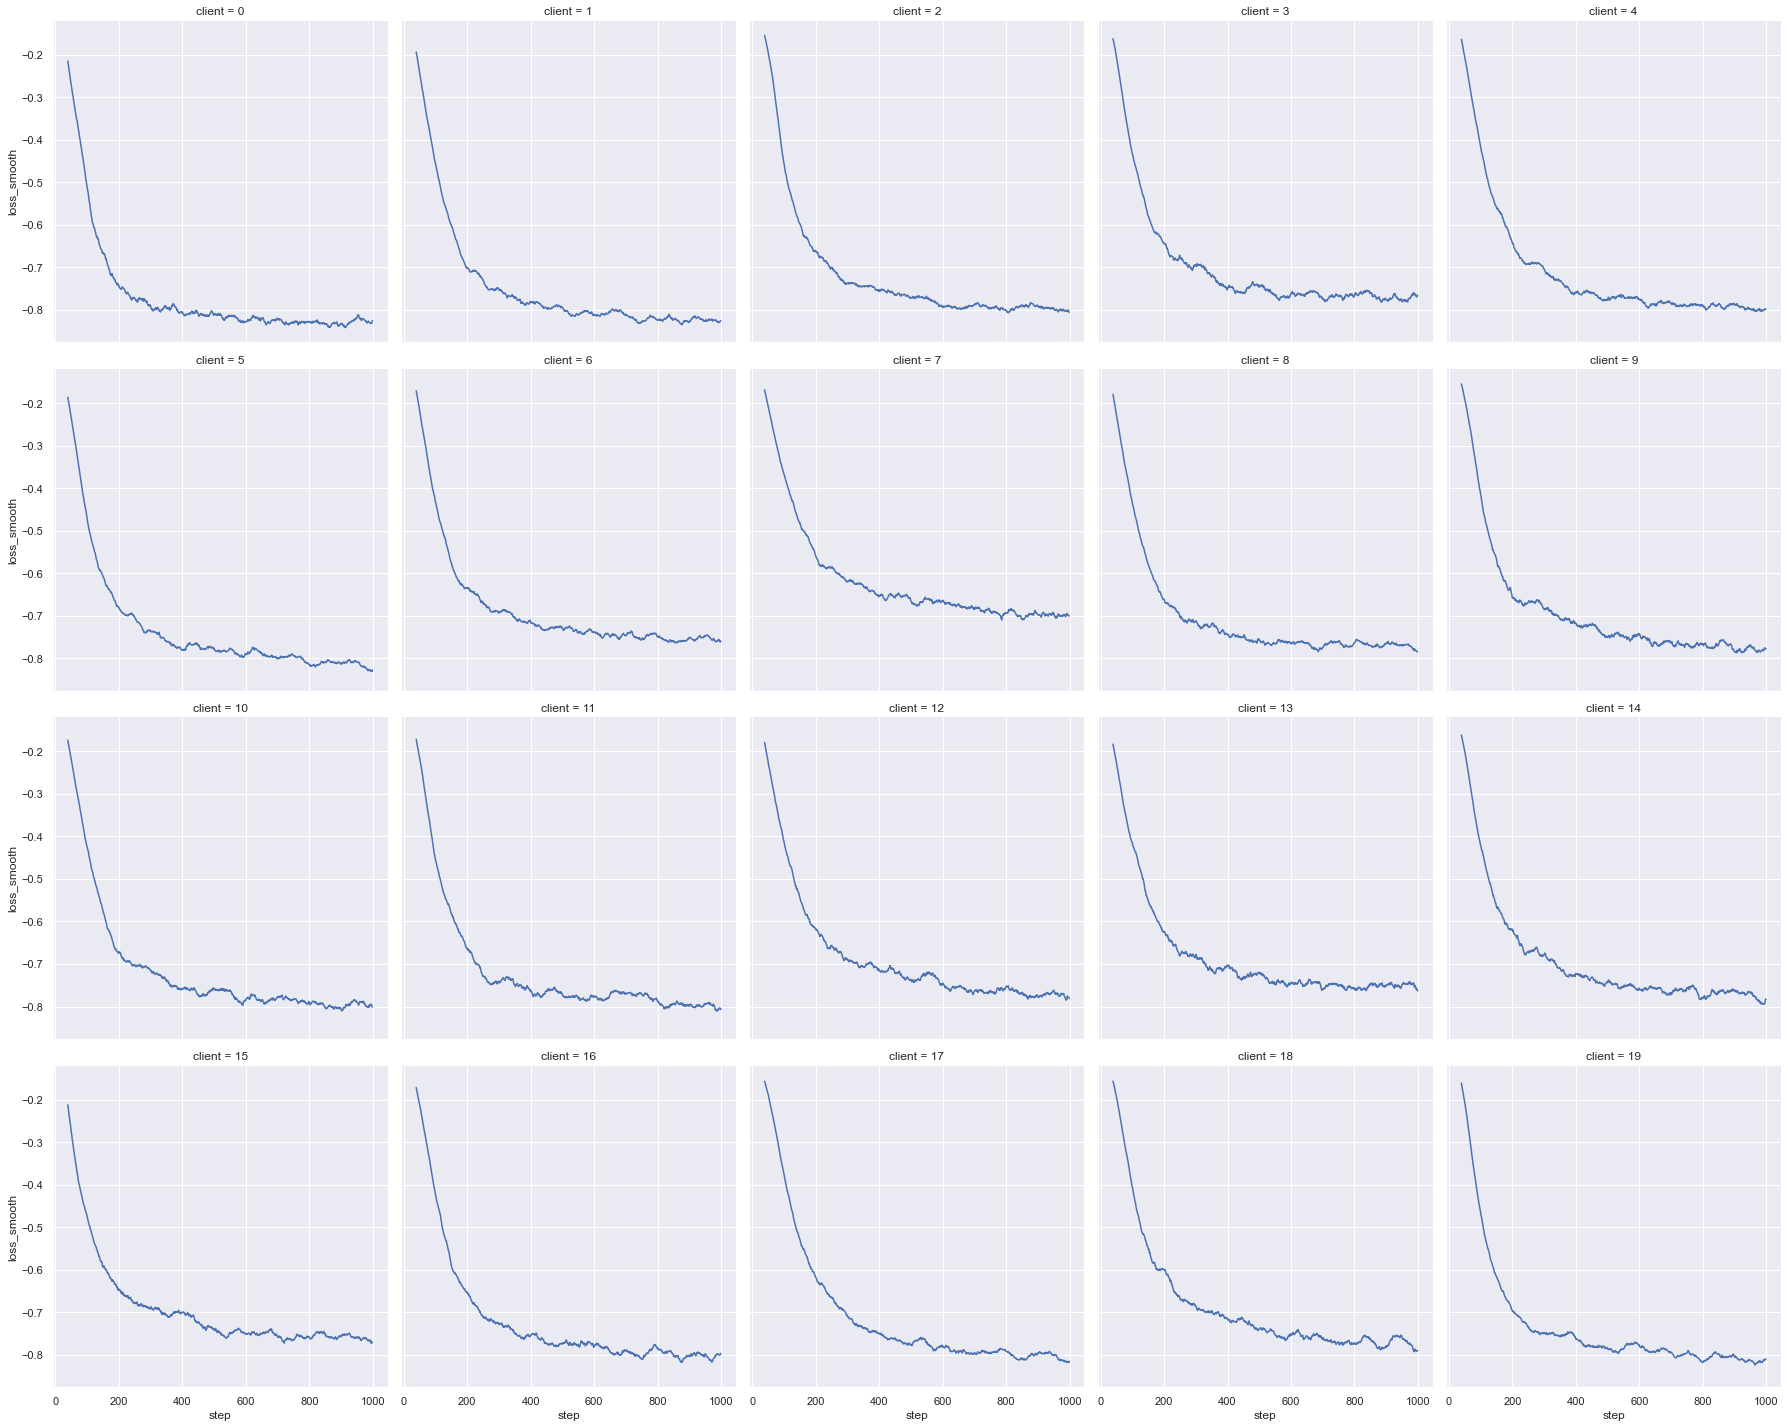

In [11]:
sns.relplot(x="step", y="loss_smooth", col="client", kind="line", data=runs, col_wrap=5)

In [12]:
avg_client_loss_1 = np.mean(runs['loss_smooth'][999::1000])